In [1]:
import tensorflow as tf
from flows import DistLSTM, NormalRW, DFlow, NVPFlow, LogNormal, GVAR, phase,\
Normal, floatX, MVNormal, MVNormalRW, Linear
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from tensorflow.contrib.distributions import WishartCholesky
import flows
import math

np.random.seed(1234)

Instructions for updating:
Use the retry module or similar alternatives.


In [2]:
data = pd.read_csv('./data/test_aus_data.csv').values.astype(floatX).T[np.newaxis][:,1:]/100

In [3]:
data = data[:,1:] - data[:,:-1]

In [4]:
stds = (data[0,1:] - data[0,:-1]).std(axis=0)
print(stds)
data /= stds

[0.02801256 0.03272164 0.01101932]


In [5]:
np.any(np.isnan(data))

False

In [6]:
xs = data

In [7]:
n = data.shape[1]
s1_prior_d = LogNormal(1, mu=math.log(0.01), sigma=1.)

with tf.variable_scope('s1_inference', dtype=floatX):
    mu = tf.get_variable('mu', shape=[1], initializer=tf.constant_initializer(s1_prior_d.mu))
    logsigma = tf.get_variable('logsigma', shape=[1], 
                               initializer=tf.constant_initializer(math.log(s1_prior_d.sigma) - 1.))
    sigma = tf.exp(logsigma)
    s1_d = LogNormal(1, mu=mu, sigma=sigma)
    
s1 = s1_d.sample()
tf.summary.scalar('s1_ord', s1[0])
s1_prior = s1_prior_d.logdens(s1)
    
incr_prior_d = LogNormal(1, mu=math.log(3.), sigma=.4)
with tf.variable_scope('incr_inference', dtype=floatX):
    mu = tf.get_variable('mu', shape=[1], initializer=tf.constant_initializer(incr_prior_d.mu))
    logsigma = tf.get_variable('logsigma', shape=[1], 
                               initializer=tf.constant_initializer(math.log(incr_prior_d.sigma) - 1.))
    sigma = tf.exp(logsigma)
    incr_d = LogNormal(1, mu=mu, sigma=sigma)
    
incr = incr_d.sample()
incr_prior = incr_prior_d.logdens(incr)

incr += 1.
s_shock = s1*incr
tf.summary.scalar('s1_shock', s_shock[0])
s0 = 80.
dim = [3,4]

k = dim[0] * dim[1]
# with tf.variable_scope('pwalk_inf', reuse=tf.AUTO_REUSE):
#     ldiag = DFlow([NVPFlow(dim=k, name='ldiag_flow_' + str(i)) for i in range(4)])
#     ldiag.logdens -= tf.reduce_sum(ldiag.output)
# PWalk = MVNormalRW(dim[0]*dim[1], sigma=s1, sigma0=s0, name='OrdWalk', 
#                    ldiag=ldiag.output[0]+np.log(1/s1))
# PWalk_shock = MVNormalRW(dim=dim[0]*dim[1], sigma0=s0, sigma=s_shock, name='ShockWalk', 
#                        ldiag=ldiag.output[0]+np.log(1/s1)-np.log(0.5))
# PWalk = MVNormalRW(dim[0]*dim[1], sigma=s1, sigma0=s0, name='param_walk_prior')
PWalk = NormalRW(dim=None, sigma0=s0, sigma=s1, name='OrdWalk')
PWalk_shock = NormalRW(dim=None, sigma0=s0, sigma=s_shock, name='ShockWalk')

In [8]:
def autoregr_tf(X, param):
    d = param[:,:dim[-1]-1]
    X = tf.matmul(X, d) + param[:,-1][np.newaxis]
    return X

In [9]:
gvar = GVAR(dim=dim[0]*dim[1], len=data.shape[1], name='coef_rw_inference')
outputs = gvar.sample()
outputs_logdens = gvar.logdens

In [10]:
outputs_logdens

<tf.Tensor 'coef_rw_inference_1/VAR/logdens/add:0' shape=() dtype=float64>

In [11]:
outputs

<tf.Tensor 'coef_rw_inference_1/VAR/strided_slice_36:0' shape=(1, 36, 12) dtype=float64>

In [12]:
prior_ord = PWalk.logdens(outputs, reduce=False)
prior_shock = PWalk_shock.logdens(outputs, reduce=False)

In [13]:
prior_ord, prior_shock

(<tf.Tensor 'OrdWalk_2/concat:0' shape=(1, 36) dtype=float64>,
 <tf.Tensor 'ShockWalk_2/concat:0' shape=(1, 36) dtype=float64>)

In [14]:
# aux = tf.range(0,data.shape[1]-1, dtype=floatX)[tf.newaxis,:,tf.newaxis]
# aux

In [15]:
# shock_d = DistLSTM(2, name='Shock_Distr', sample_len=data.shape[1], state_dim=48, num_layers=1)
with tf.variable_scope('Shock_Distr', dtype=floatX):
    logits = tf.get_variable('bern_logits', shape=[1,data.shape[1],1], 
                             initializer=tf.random_normal_initializer(stddev=0.1, mean=-1.))
    shock_d = tf.distributions.Bernoulli(logits=logits)

In [16]:
shocks = shock_d.sample()
spd = tf.contrib.distributions.Poisson(rate=4.)

In [17]:
penalty = tf.Variable(0, trainable=False)
penalty_op = None#tf.assign_sub(penalty, 1.)
tf.summary.scalar('penalty', penalty)
with tf.name_scope('shock_prior'):
    num_shocks = tf.reduce_sum(tf.cast(shocks[:,:,0], tf.float32))
    sp = spd.log_prob(num_shocks)
    shock_prior = tf.where(tf.abs(num_shocks - 4) < 0.5, 0, penalty)
    shock_prior = tf.cast(shock_prior, tf.float64) + tf.cast(sp, floatX)
    
    tf.summary.scalar('num_shocks', num_shocks)
    tf.summary.scalar('shock_prior', shock_prior)

In [18]:
with tf.name_scope('RW_prior'):
    tmp = tf.cast(shocks[:,:,0], floatX)
    prior = tmp*prior_shock + (1-tmp)*prior_ord
    prior = tf.reduce_sum(prior) + shock_prior
    
    tf.summary.scalar('prior', prior)

In [19]:
obs_d_prior = LogNormal(dim=None, mu=math.log(0.5), sigma=0.5)

with tf.variable_scope('obs_d_inference', dtype=floatX):
    mu = tf.get_variable('mu', shape=[1], initializer=tf.constant_initializer(math.log(0.5)))
    logsigma = tf.get_variable('logsigma', shape=[1], initializer=tf.constant_initializer(-5))
    sigma = tf.exp(logsigma)
    obs_d_post = LogNormal(1, mu=mu, sigma=sigma)
    obs_ds = obs_d_post.sample()
    obs_ds_logdens = obs_d_post.logdens(obs_ds)
    tf.summary.scalar('observ_sigma', obs_ds[0])

In [20]:
xs.shape

(1, 36, 3)

In [21]:
def predict(observable_mask):
    out = tf.reshape(outputs, [n, dim[0], dim[1]])
    
    def step(prev, x):
        mask = x[0]
        prev_pred = tf.where(mask, x[1], prev)[tf.newaxis]
        params = x[2]
        
        d = params[:,:-1]
        new_pred = tf.matmul(prev_pred, d)[0] + params[:,-1]
        return new_pred
    
    ar = tf.scan(step, [observable_mask, xs[0], out], initializer=tf.zeros([dim[0]], dtype=floatX))
    return ar

In [22]:
stop_time = tf.placeholder(tf.int32)
predict_mask = tf.range(0, data.shape[1], dtype=tf.int32) < stop_time
#используем в предсказаниях ровно stop_time последних наблюдений

In [23]:
preds = predict(predict_mask)

In [24]:
preds

<tf.Tensor 'scan/TensorArrayStack/TensorArrayGatherV3:0' shape=(?, 3) dtype=float64>

In [25]:
# sess = tf.InteractiveSession()
# tf.global_variables_initializer().run()

In [26]:
obs_d = Normal(dim=None, sigma=obs_ds, mu=0)

In [27]:
diffs = preds[:-1] - xs[0,1:]

In [28]:
logl = obs_d.logdens(diffs, reduce=False)
logl *= tf.cast(predict_mask[:-1], floatX)[:,tf.newaxis]

logl = tf.reduce_sum(logl)

In [29]:
tf.summary.scalar('logl', logl)

<tf.Tensor 'logl:0' shape=() dtype=string>

In [30]:
# df = dim[0]*dim[1]
# pmat = np.diag([(1/s1**2)]*(dim[0]*dim[1]))/df
# cov_prior = WishartCholesky(df, pmat, cholesky_input_output_matrices=True)

In [31]:
xs.shape

(1, 36, 3)

In [32]:
# shock_d.log_prob(shocks)

In [33]:
td = shock_d.log_prob(shocks)[:,:,0]
print(td)
shock_prob = tf.reduce_sum(td)
tf.summary.scalar('shock_ent', -shock_prob)

Tensor("strided_slice_5:0", shape=(1, 36), dtype=float64)


<tf.Tensor 'shock_ent:0' shape=() dtype=string>

In [34]:
td

<tf.Tensor 'strided_slice_5:0' shape=(1, 36) dtype=float64>

In [35]:
shocks

<tf.Tensor 'Bernoulli/sample/Reshape:0' shape=(1, 36, 1) dtype=int32>

In [36]:
prior += incr_prior + s1_prior + obs_d_prior.logdens(obs_ds)

In [37]:
KLd = -logl - prior + outputs_logdens + shock_prob + obs_ds_logdens# - cov_prior.log_prob(PWalk.fsigma) + ldiag.logdens# + lowerd.logdens
KLd /= n*dim[0]*dim[1]

In [38]:
KLd

<tf.Tensor 'truediv:0' shape=() dtype=float64>

In [39]:
with tf.variable_scope('CV'):
    baseline = flows.baselines.LSTMBL(reuse=None, num_layers=1, state_dim=48)

    reinforce_target = baseline(tf.cast(shocks, floatX), td, KLd)
    baseline_grads = baseline.get_grads()

Tensor("CV/LSTMBL_1/scan/while/TensorArrayReadV3:0", shape=(1, 1), dtype=float64)
Tensor("CV/LSTMBL_1/scan/while/TensorArrayReadV3_1:0", shape=(1,), dtype=float64)
Tensor("CV/LSTMBL_1/scan/while/strided_slice:0", shape=(), dtype=float64)
<tf.Variable 'CV/LSTMBL/init_baseline:0' shape=(1,) dtype=float64_ref>
Tensor("CV/LSTMBL_1/truediv:0", shape=(1,), dtype=float64)


In [40]:
baseline_grads

[(<tf.Tensor 'CV/gradients/CV/LSTMBL_1/sub_1_grad/Reshape:0' shape=(1,) dtype=float64>,
  <tf.Variable 'CV/LSTMBL/init_baseline:0' shape=(1,) dtype=float64_ref>),
 (<tf.Tensor 'CV/gradients/CV/LSTMBL_1/scan/while/LSTMBL/multi_rnn_cell/cell_0/cell_0/MatMul/Enter_grad/b_acc_3:0' shape=(49, 192) dtype=float64>,
  <tf.Variable 'CV/LSTMBL/multi_rnn_cell/cell_0/cell_0/kernel:0' shape=(49, 192) dtype=float64_ref>),
 (<tf.Tensor 'CV/gradients/CV/LSTMBL_1/scan/while/LSTMBL/multi_rnn_cell/cell_0/cell_0/BiasAdd/Enter_grad/b_acc_3:0' shape=(192,) dtype=float64>,
  <tf.Variable 'CV/LSTMBL/multi_rnn_cell/cell_0/cell_0/bias:0' shape=(192,) dtype=float64_ref>),
 (<tf.Tensor 'CV/gradients/CV/LSTMBL_1/scan/while/d1/MatMul/Enter_grad/b_acc_3:0' shape=(48, 1) dtype=float64>,
  <tf.Variable 'CV/LSTMBL/d1/W:0' shape=(48, 1) dtype=float64_ref>),
 (<tf.Tensor 'CV/gradients/CV/LSTMBL_1/scan/while/d1/add/Enter_grad/b_acc_3:0' shape=(1, 1) dtype=float64>,
  <tf.Variable 'CV/LSTMBL/d1/b:0' shape=(1, 1) dtype=floa

In [41]:
shock_vars = [x for x in tf.global_variables() if 'Shock_Distr' in x.name]
shock_vars

[<tf.Variable 'Shock_Distr/bern_logits:0' shape=(1, 36, 1) dtype=float64_ref>]

In [42]:
# shock_reinforce = tf.gradients(shock_prob, shock_vars)

# with tf.variable_scope('CV', dtype=floatX, initializer=tf.random_normal_initializer(stddev=0.1)):
#     cv = tf.get_variable('cv', shape=(1,), trainable=False)
#     cv_op = cv.assign(0.96*cv + 0.04*KLd)
    
# shock_reinforce = [x*(KLd-cv) for x in shock_reinforce]
shock_reinforce = tf.gradients(reinforce_target, shock_vars)

In [43]:
# cv_loss = [tf.reduce_mean(x*x) for x in shock_reinforce]
# cv_loss = tf.reduce_mean(cv_loss)
# tf.summary.scalar('cv_loss', cv_loss)
tf.summary.scalar('cv_loss', baseline.loss[0])

# cv_gradients = tf.gradients(cv_loss, controls)

<tf.Tensor 'cv_loss:0' shape=() dtype=string>

In [44]:
baseline.loss

<tf.Tensor 'CV/LSTMBL_1/add:0' shape=(1,) dtype=float64>

In [45]:
rest_vars = [x for x in tf.global_variables() if not ('CV' in x.name or 'Shock_distr' in x.name)]
rest_gradients = tf.gradients(KLd, rest_vars)

In [46]:
all_vars = shock_vars + rest_vars# + controls 
grads = shock_reinforce + rest_gradients# + cv_gradients 
updates = [(g,x) for x,g in zip(all_vars, grads)] + baseline_grads

In [47]:
KLd

<tf.Tensor 'truediv:0' shape=() dtype=float64>

In [48]:
tf.summary.scalar('KLd', KLd)

<tf.Tensor 'KLd:0' shape=() dtype=string>

In [49]:
lr = tf.Variable(0.0003)
opt = tf.train.AdamOptimizer(lr)

In [50]:
opt = opt.apply_gradients(updates)#, cv_op]

In [51]:
sess = tf.InteractiveSession()

In [52]:
# !rm -R /tmp/tfdbg
!mkdir /tmp/tfdbg
writer = tf.summary.FileWriter('/tmp/tfdbg/aus_data_bern')

mkdir: cannot create directory ‘/tmp/tfdbg’: File exists


In [53]:
writer.add_graph(tf.get_default_graph())

In [54]:
tf.global_variables_initializer().run()

In [55]:
KLd.eval({stop_time:data.shape[1]})

0.8280994262999334

In [56]:
np.set_printoptions(precision=3)

In [57]:
# PWalk.inverse_sigma.eval()[:3,:3]

In [58]:
out = tf.reshape(outputs, [n, dim[0], dim[1]])

In [59]:
epoch = 0

In [60]:
all_sum = tf.summary.merge_all()

In [61]:
# for epoch in range(epoch, 20):
#     for i in range(800):
#         l, _ = sess.run([loss, opt], {phase:False})
#     print(l)

In [62]:
def check_ppc(timestep):
    n = 1000
    all_preds = []
    for _ in range(n):
        tp = preds.eval({stop_time:timestep-1})
        tp = tp[timestep-1]
        all_preds.append(tp)
    all_preds = np.array(all_preds).mean(axis=0)
#     print(xs.shape)
    return np.sqrt(np.mean((all_preds - xs[0,timestep])**2))

In [ ]:
%%time
for epoch in range(epoch, epoch+1000):
    for i in range(1000):
        l, _ = sess.run([KLd, opt], {phase:True, stop_time:[2000]})
        if i % 10 == 0 and epoch > 2:
            s = all_sum.eval({phase:True, stop_time:[2000]})
            writer.add_summary(s, global_step=epoch*1000 + i)
    print(l)
#     if epoch % 10 == 0:
#         penalty_op.eval()
#     print(PWalk.inverse_sigma.eval()[:3,:3])
#     print('\n')

0.42014850705729523
0.41291770416872803


In [71]:
penalty_op.eval()

-4

In [85]:
penalty.assign(-3).eval()

-3

In [58]:
ppcs = []
for i in range(1, 33):
    ppcs.append(check_ppc(i))

IndexError: index 20 is out of bounds for axis 1 with size 20

In [58]:
plt.plot(ppcs)
plt.show()

NameError: name 'ppcs' is not defined

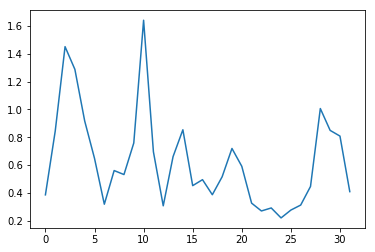

In [59]:
plt.plot(ppcs)
plt.show()

In [61]:
epoch

39

In [83]:
lr.assign(0.0001).eval()

1e-04

In [64]:
ss = []
for _ in range(20000):
    s = shocks.eval()[:,:,0].astype('float')
    ss.append(s)
ss = np.array(ss)
print(ss.mean(axis=0))

[[0.315 0.222 0.202 0.188 0.205 0.207 0.195 0.203 0.217 0.187 0.219 0.217
  0.203 0.197 0.187 0.199 0.195 0.187 0.188 0.211 0.195 0.191 0.204 0.191
  0.192 0.196 0.205 0.224 0.194 0.201 0.219 0.196 0.199 0.191 0.219 0.218]]


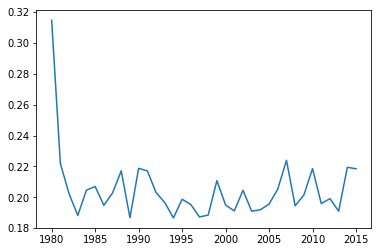

In [66]:
x = range(2016-data.shape[1],2016)
plt.plot(x, ss.mean(axis=0)[0][:])
plt.show()

In [71]:
ss = []
aa = []
for _ in range(3000):
    a = np.linalg.inv(PWalk.inverse_sigma.eval())
    ss.append(np.sqrt(np.diag(a)))
    aa.append(a)
ss = np.array(ss)
aa = np.array(aa)

AttributeError: 'NormalRW' object has no attribute 'inverse_sigma'

In [48]:
aa.mean(axis=0)[:5,:5]

array([[ 1.2923e-04, -7.1903e-09,  3.5436e-08,  6.2896e-08,  3.5567e-08],
       [-7.1903e-09,  1.3707e-04,  9.9602e-08, -8.9267e-08,  2.4762e-08],
       [ 3.5436e-08,  9.9602e-08,  1.2321e-04,  5.1597e-08,  7.2189e-08],
       [ 6.2896e-08, -8.9267e-08,  5.1597e-08,  1.2432e-04, -7.2140e-08],
       [ 3.5567e-08,  2.4762e-08,  7.2189e-08, -7.2140e-08,  1.3892e-04]])

In [49]:
np.mean(ss, axis=0), np.std(ss, axis=0)

(array([0.0112, 0.0115, 0.0109, 0.011 , 0.0116, 0.0112, 0.0116, 0.0117,
        0.0098, 0.0093, 0.01  , 0.011 ]),
 array([0.0018, 0.002 , 0.0019, 0.0019, 0.002 , 0.0018, 0.0019, 0.0019,
        0.0017, 0.0015, 0.0016, 0.0017]))

In [72]:
# sns.kdeplot(ss[:,1], ss[:,0])
# plt.show()

In [51]:
samples = []
for _ in range(3000):
    s = out.eval({phase:True})
    samples.append(s)
samples = np.array(samples)

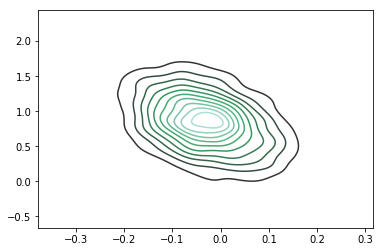

In [52]:
t = 10
sns.kdeplot(samples[:,t,2,0], samples[:,t,0,3])
plt.show()

In [53]:
t = 10
# params[t]

In [54]:
np.mean(samples[:,t], axis=0)

array([[ 0.535, -0.093,  0.349,  0.84 ],
       [ 0.044,  0.364,  0.363,  0.444],
       [-0.033,  0.284,  0.716,  0.582]])

In [57]:
np.mean(samples[:,t], axis=0)

array([[ 1.784e-01, -4.327e-01,  6.377e-01,  1.247e+00],
       [ 2.535e-01, -3.870e-01,  5.534e-01,  3.942e-01],
       [ 6.316e-04,  2.550e-01,  7.469e-01,  2.270e-01]])

In [278]:
from sklearn.neighbors.kde import KernelDensity
def score(s1, s2):
    bw = 0.1
    s1 = s1[:,np.newaxis]
    s2 = s2[:,np.newaxis]
    e1 = KernelDensity(bandwidth=bw).fit(s1)
    e2 = KernelDensity(bandwidth=bw).fit(s2)
    
    e1e2 = e1.score(s1) - e2.score(s1)
    e2e1 = e2.score(s2) - e1.score(s2)
    dist = (e1e2/len(s1) + e2e1/len(s2))/2
    return dist

In [271]:
def get_cdf(ts):
    return lambda x: (ts <= x).mean()
def score(s1,s2):
    c1 = get_cdf(s1)
    c2 = get_cdf(s2)

    m = 0
    for s in np.concatenate([s1, s2]):
        r = np.abs(c1(s) - c2(s))
        if r > m:
            m = r
    return m

In [203]:
score(s1,s2)

0.00014521624382734903

In [279]:
dists = []
for t1 in range(samples.shape[1] - 1):
    np.random.seed(1234)
    print(t1)
    t2 = t1 + 1
    s1 = samples[:,t1,0,0]
    s2 = samples[:,t2,0,0]
    ss = []
    for _ in range(10):
        s1_ = np.random.choice(s1, size=8000)
        s2_ = np.random.choice(s2, size=8000)
        m = score(s1_,s2_)
        ss.append(m)
    dists.append(ss)
dists = np.array(dists).T

0
1
2
3
4
6
7
8
9
10
11
12
13
14
15
16
17
18


## KDE + KL

/home/nikita/.virtualenvs/py3.6/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


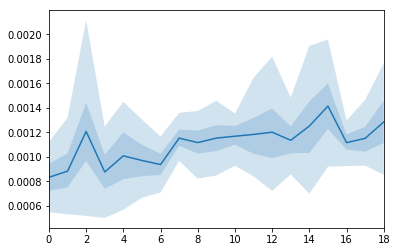

In [270]:
sns.tsplot(dists, ci=[50, 95])
plt.show()

/home/nikita/.virtualenvs/py3.6/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


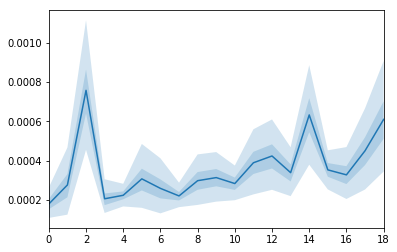

In [280]:
sns.tsplot(dists, ci=[50, 95])
plt.show()

## Kolmogorov-Smirnov

/home/nikita/.virtualenvs/py3.6/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


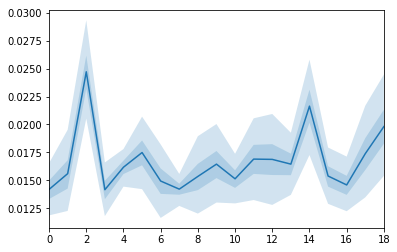

In [277]:
sns.tsplot(dists, ci=[50, 95])
plt.show()

In [ ]:
tf.pow()